# Analyze

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

plt.rcParams["font.family"] = "UGent Panno Text"
plt.rcParams["font.size"] = 28

import tools.common_functions as cf
import tools.plotting_functions as pf

# Parameters
SENSOR_LAG = 25 # ms
ARRAY_W = 4
ARRAY_H = 8
ARRAY_SIZE = ARRAY_W * ARRAY_H

TAXEL_ID = 0

NAME = f"table_calibration/taxel{TAXEL_ID}"


In [3]:
angle = -7

original_data = cf.prepare_data_for_fitting(NAME, ARRAY_SIZE, SENSOR_LAG, False)

F_x = original_data['F_x'] * np.cos(np.deg2rad(angle)) - original_data['F_y'] * np.sin(np.deg2rad(angle))
F_y = original_data['F_x'] * np.sin(np.deg2rad(angle)) + original_data['F_y'] * np.cos(np.deg2rad(angle))
  
original_data['F_x'] = F_x.copy()
original_data['F_y'] = F_y.copy()
  
  
original_data.head()

Preparing data for fitting: table_calibration/taxel0


/home/lowiek/masters-thesis/notebooks/tools/common_functions.py:310: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data[col] -= mean_without_outliers(data[col][:window])


,index,t_wall,level_sensor,X0,Y0,Z0,X1,Y1,Z1,X2,...,level_robot,F_x,F_y,F_z,T_x,T_y,T_z,X,Y,Z
9,0,1.713384e+09,0.0,4.306394,4.103515,-6.954206e-08,0.574765,0.402353,3.699180e-08,-1.449323,...,0.0,0.059585,-0.013469,0.055963,0.001305,0.001813,0.002141,-0.209223,-0.187061,-0.148509
10,9488,1.713384e+09,0.0,4.006394,3.403515,-6.062051e-08,0.654765,0.322353,2.962210e-08,-1.169323,...,0.0,0.034601,-0.018629,0.015333,0.002404,0.000769,0.002098,-0.209219,-0.187055,-0.148510
11,9489,1.713384e+09,0.0,3.706394,2.703515,-5.169720e-08,0.734765,0.242353,2.225333e-08,-0.889323,...,0.0,0.053566,0.009518,-0.039036,0.003937,0.001630,0.003106,-0.209236,-0.187061,-0.148512
12,9490,1.713384e+09,0.0,3.406394,2.003515,-4.277212e-08,0.814765,0.162353,1.488551e-08,-0.609323,...,0.0,0.060130,-0.065065,0.041063,0.001552,0.001524,0.003319,-0.209240,-0.187052,-0.148513
13,9491,1.713384e+09,0.0,3.106394,1.303515,-3.384527e-08,0.894765,0.082353,7.518613e-09,-0.329323,...,0.0,0.174983,-0.033922,0.143764,0.001938,0.004243,0.002691,-0.209279,-0.187077,-0.148494


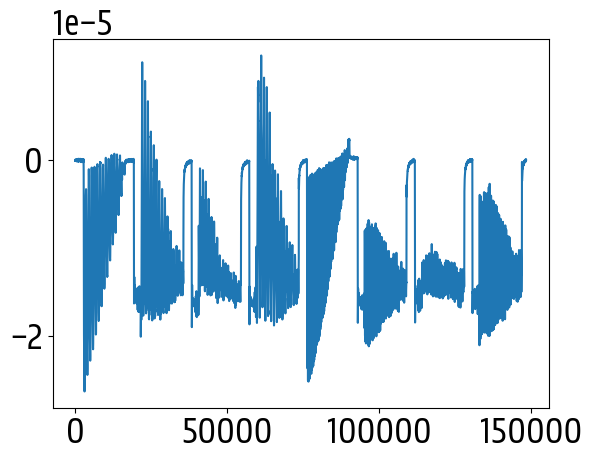

In [4]:
plt.plot(original_data[f"Z{TAXEL_ID}"])

In [5]:
import os
import dill
    
save_path = os.path.join(os.getcwd(), '..', 'models', "4x8")
with open(os.path.join(save_path, f"stageII"), 'rb') as f:
    stage_II_model = dill.load(f)     
with open(os.path.join(save_path, f"stageI"), 'rb') as f:
    stage_I_model = dill.load(f)  
with open(os.path.join(save_path, f"stageI_alt"), 'rb') as f:
    stage_I_alt_model = dill.load(f)        

In [6]:
forces = stage_I_model.predict(original_data)
forces_alt = stage_I_alt_model.predict(original_data)

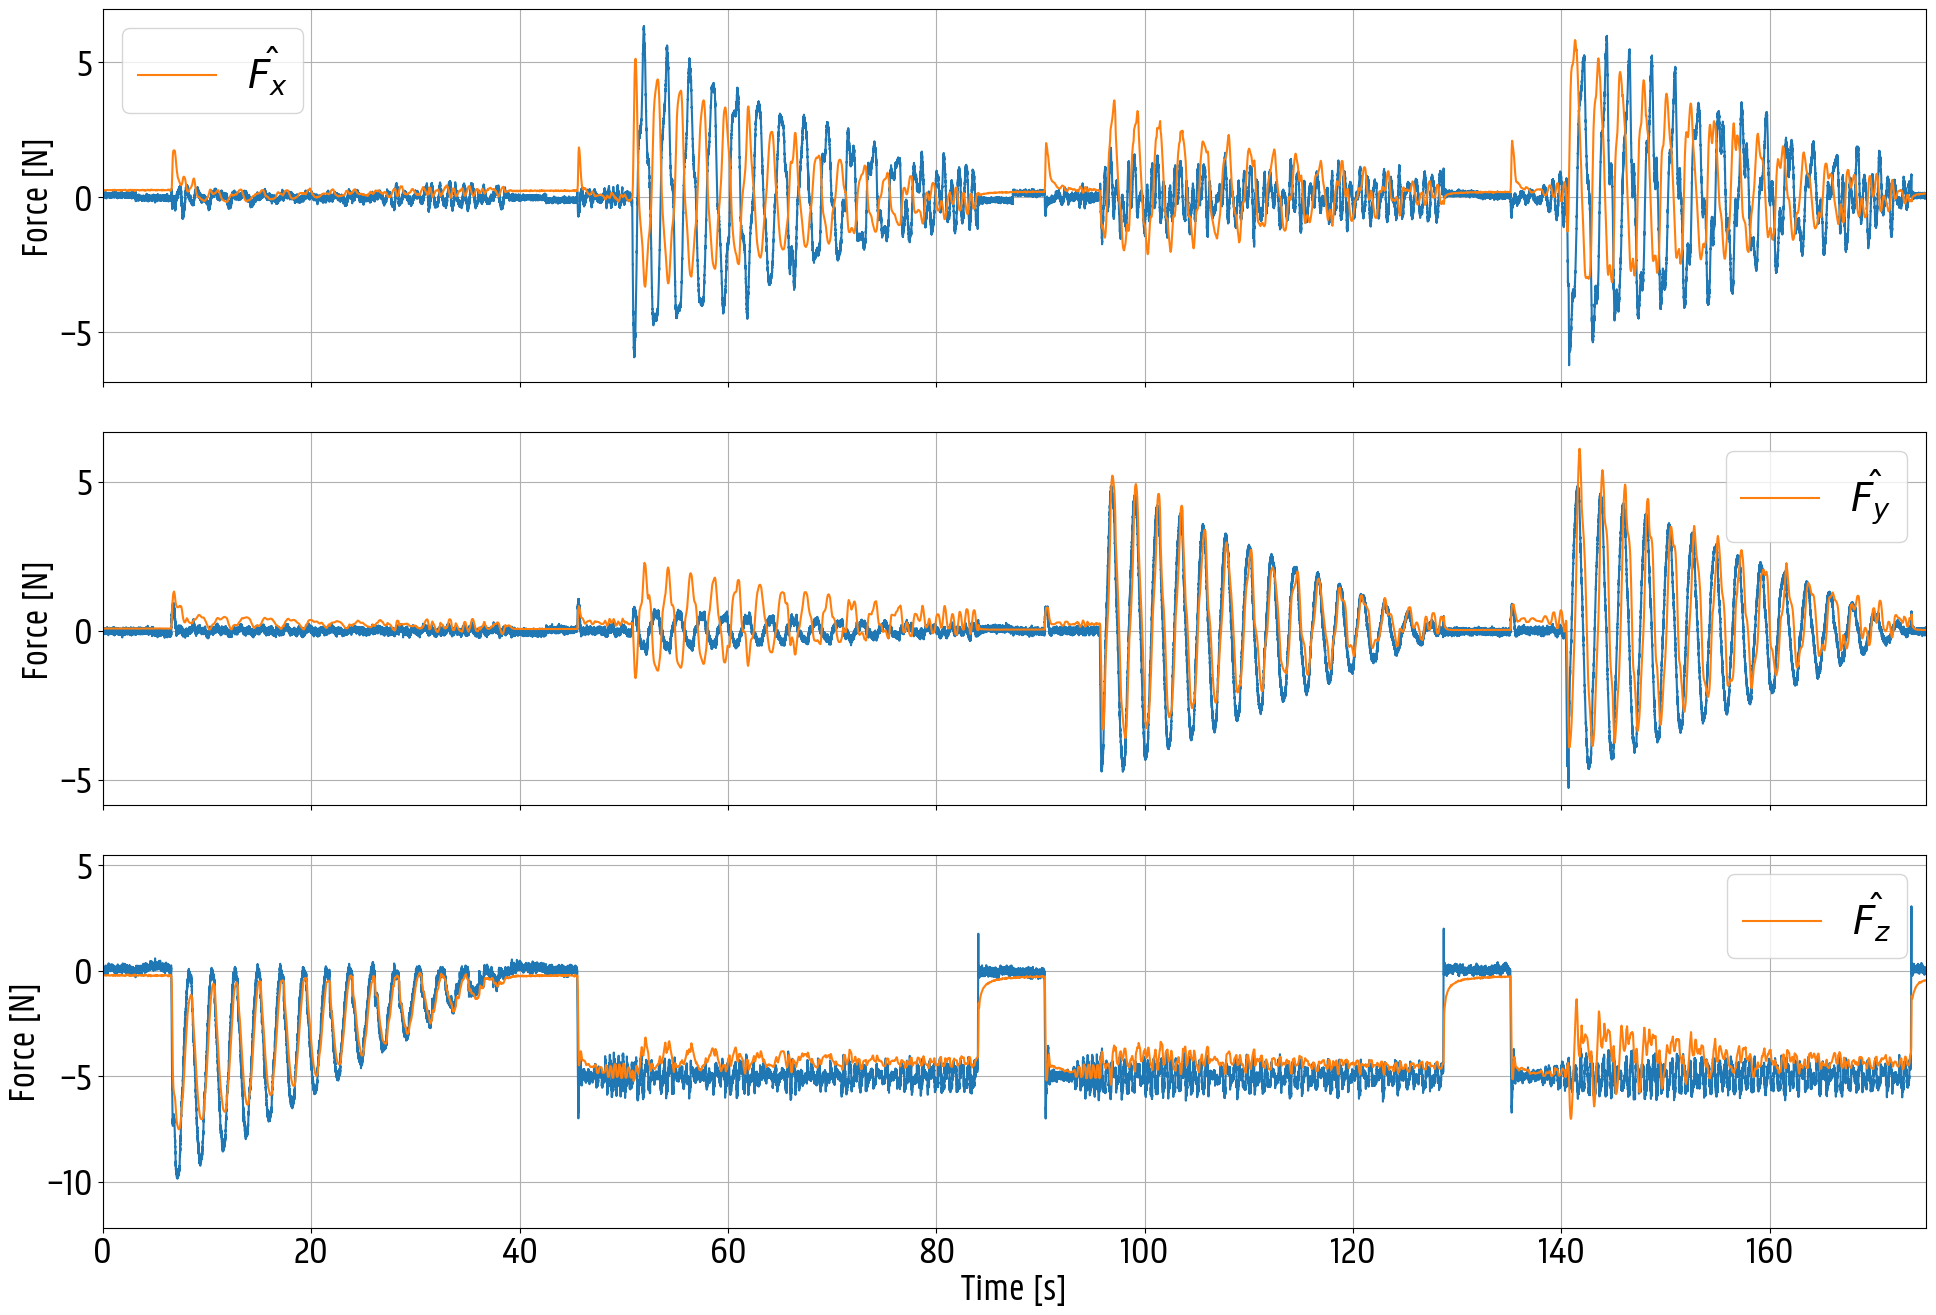

In [8]:
# Extract prediction data
columns = [f'X{TAXEL_ID}', f'Y{TAXEL_ID}', f'Z{TAXEL_ID}']


# Create subplots
fig, ax = plt.subplots(3, 1, figsize=(20, 15), sharex=True, sharey=False)

# Define common labels and titles
axes_labels = ['$F_x$', '$F_y$', '$F_z$']
axes_vals = ['F_x', 'F_y', 'F_z']
pred_labels = ['$\hat{F_x}$', '$\hat{F_y}$', '$\hat{F_z}$']
titles = ['X-axis Force Prediction', 'Y-axis Force Prediction', 'Z-axis Force Prediction']
colors = ['r', 'g', 'b']

t = np.linspace(0, int(350), len(original_data))

for i, axi in enumerate(ax):
    axi.plot(t, original_data[axes_vals[i]])#[:int(len(taxels_data[0]) / 2)], label=f'{axes_labels[i]}')
    
    # Y_pred = stage_I_model.predict(original_data)[0]
    # axi.plot(t, Y_pred[:, i], label=pred_labels[i])
    
    Y_pred = stage_I_alt_model.predict(original_data)[0]
    axi.plot(t, Y_pred[:, i], label=pred_labels[i])
    
    axi.set_ylabel('Force [N]')
    # axi.set_title(titles[i])
    axi.legend()
    axi.grid(True)

# Set common x-label for the entire figure
ax[-1].set_xlabel('Time [s]')
ax[-1].set_xlim([0, 350/2])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the plot
plt.savefig("plots/c4_stageI_fit_cv.pdf", format="pdf", bbox_inches="tight")
plt.show()

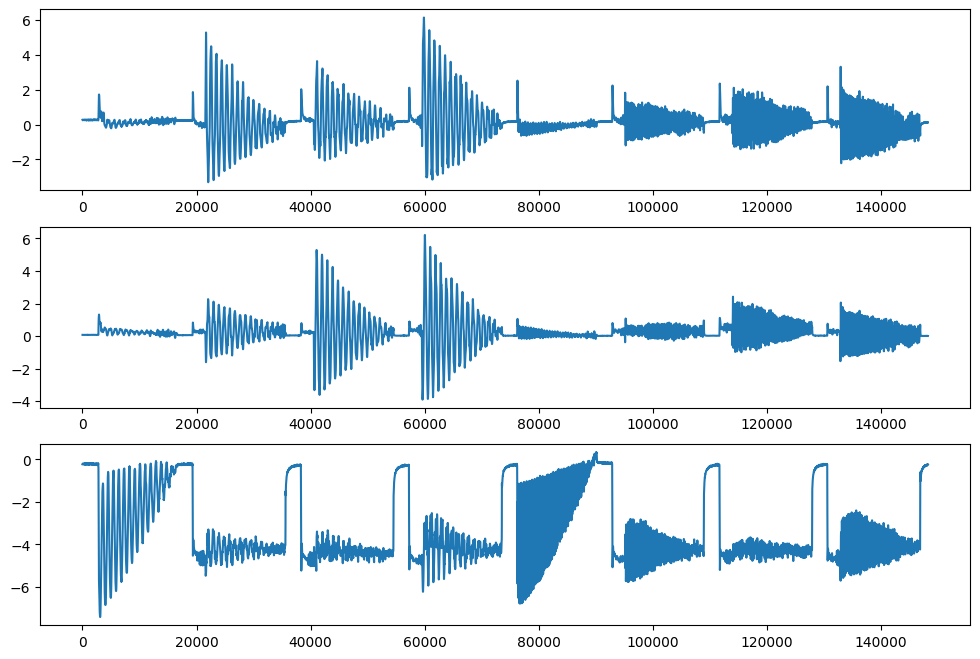

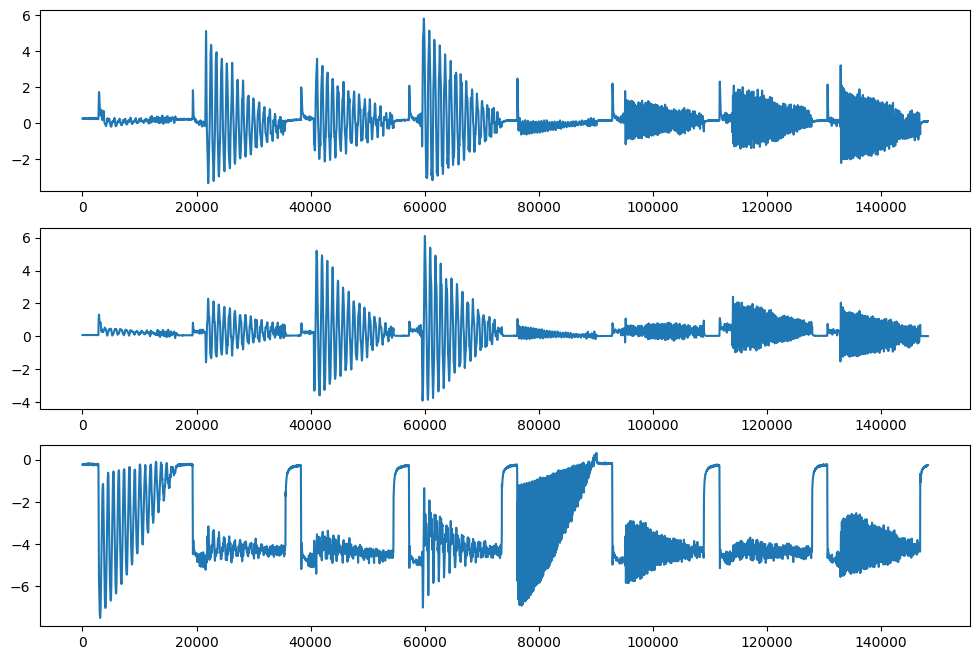

In [13]:
pf.plot_three_components(forces[TAXEL_ID].T)
pf.plot_three_components(forces_alt[TAXEL_ID].T)

/tmp/ipykernel_7754/1842955071.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(original_data["Z"][78000:92000])


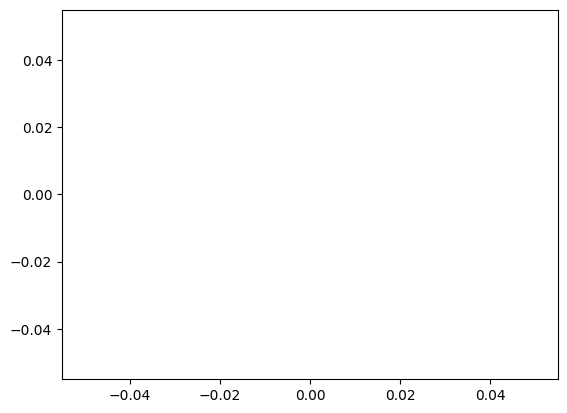

In [58]:
plt.plot(original_data["Z"][78000:92000])

/tmp/ipykernel_54453/3434382354.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(original_data["F_z"][78000:92000])


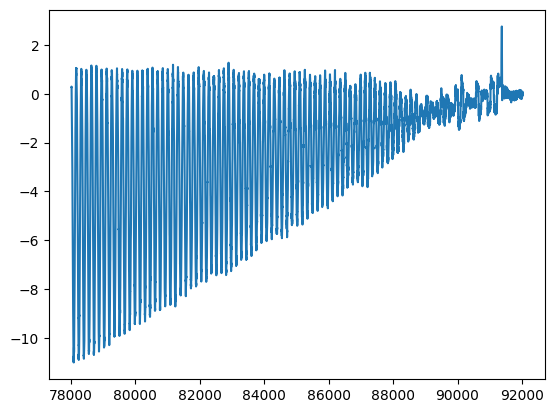

In [15]:
plt.plot(original_data["F_z"][78000:92000])

/tmp/ipykernel_60551/282070990.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(original_data["Z28"][0:18000], original_data["F_z"][0:18000])


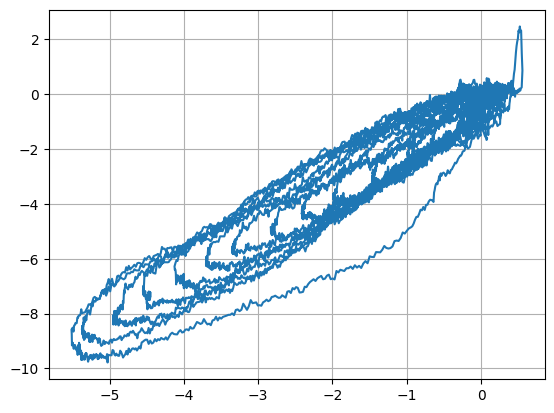

In [9]:
plt.plot(original_data["Z28"][0:18000], original_data["F_z"][0:18000])
plt.grid()
# plt.plot(original_data["Z28"][75000:90000], original_data["F_z"][75000:90000])
# plt.plot(original_data["Z28"][18000:25000], original_data["F_z"][18000:25000])

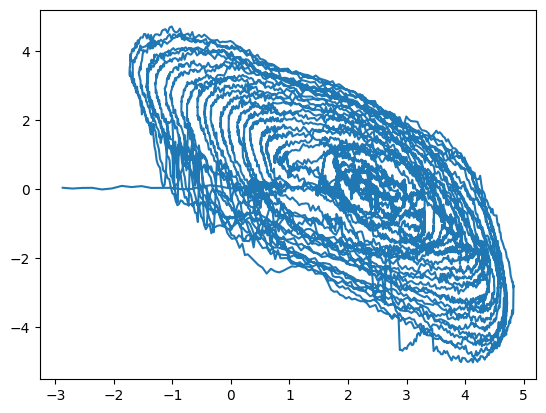

In [38]:
plt.plot(original_data["X28"], original_data["F_y"])

/tmp/ipykernel_60193/374818657.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(original_data["Z28"][30000:40000], original_data["F_z"][30000:40000])


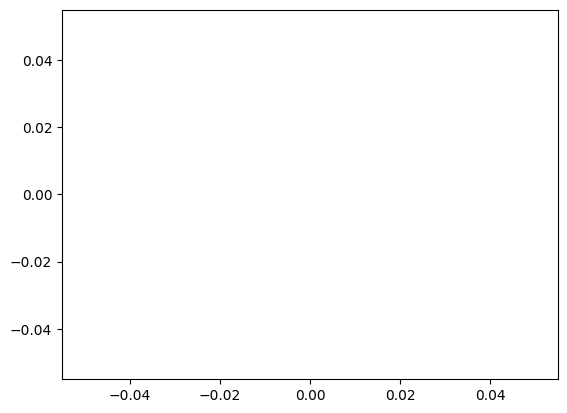

In [35]:
plt.plot(original_data["Z28"][30000:40000], original_data["F_z"][30000:40000])